In [1]:
import numpy as np 
import pandas as pd 
from pandas.api.types import CategoricalDtype
from sklearn import model_selection, ensemble, metrics, linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import os

/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
base_dir = '../data'
print(os.listdir(base_dir))

['test.pkl', 'diamonds.csv', 'train.pkl']


In [3]:
df_diamonds = pd.read_csv('%s/diamonds.csv'%(base_dir), index_col='Unnamed: 0')
df_diamonds.fillna(0)
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Numeric Features 
* Carat: weight of the diamond
* depth: depth %  The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
* table: table % The width of the diamond's table expressed as a percentage of its average diameter
* price: the price of the diamond
* xlength: mm
* ywidth: mm
* zdepth: mm

In [4]:
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## cut 
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

In [5]:
cuts_ordered = ['Fair',
                'Good',
                'Very Good',
                'Premium',
                'Ideal']
df_diamonds['cut'] = df_diamonds['cut'].astype(CategoricalDtype(cuts_ordered, ordered=True))
print(df_diamonds['cut'].unique())
df_diamonds['cut'].describe()

[Ideal, Premium, Good, Very Good, Fair]
Categories (5, object): [Fair < Good < Very Good < Premium < Ideal]


count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

## color
mColor of the diamond, with D being the best and J the worst

In [6]:
colors_ordered = [  'J',
                    'I',
                    'H',
                    'G',
                    'F',
                    'E',
                    'D']
df_diamonds['color'] = df_diamonds['color'].astype(CategoricalDtype(colors_ordered, ordered=True))
print(df_diamonds['color'].unique())
df_diamonds['color'].describe()

[E, I, J, H, F, G, D]
Categories (7, object): [J < I < H < G < F < E < D]


count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

## clarity
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

In [7]:
clarity_codes = ['I3',
'I2',
'I1',
'SI2',
'SI1',
'VS2',
'VS1',
'VVS2',
'VVS1',
'IF',
'FL']
df_diamonds['clarity'] = df_diamonds['clarity'].astype(CategoricalDtype(clarity_codes, ordered=True))
print(df_diamonds['clarity'].unique())
df_diamonds['clarity'].describe()

[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]
Categories (8, object): [I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF]


count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

## Handcraft features
Since the measures for the diamond follow a 3d shape, we are considering here some handcraft features. 
Volume for the diamond = reflecting its size and weight. 
Ratio between the X, Y and Z.


In [8]:
df_diamonds['volume'] = df_diamonds['x'] * df_diamonds['y'] * df_diamonds['z']
df_diamonds['ratio_xy'] = df_diamonds['x'] / df_diamonds['y']
df_diamonds['ratio_xz'] = df_diamonds['x'] / df_diamonds['z']
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,ratio_xz
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,0.992462,1.625514
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.013021,1.683983
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.995086,1.753247
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,0.992908,1.596958
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,0.997701,1.578182
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,38.693952,0.994949,1.588710
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,38.830870,0.992462,1.599190
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,42.321081,0.990268,1.608696
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,36.425214,1.023810,1.554217
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,38.718000,0.987654,1.673640


In [9]:
cat_columns = df_diamonds.select_dtypes(['category']).columns.values
df_diamonds[cat_columns] = df_diamonds[cat_columns].apply(lambda x: x.cat.codes)

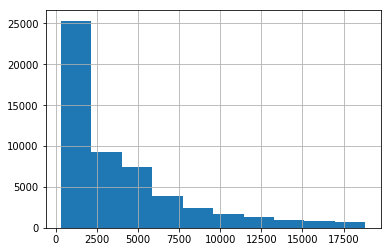

In [10]:
df_diamonds.price.hist()

In [11]:
df_diamonds.price.describe()
df_diamonds = df_diamonds.fillna(df_diamonds.mean())

In [12]:
train, test_reserved = model_selection.train_test_split(df_diamonds, test_size=0.15, random_state=42)
print(train.shape, test_reserved.shape)

(45849, 13) (8091, 13)


## Removing zeros

In [13]:
import sys
sys.path.append('../')
from diamonds import experiments
train = experiments.remove_zeros(train)
test_reserved = experiments.remove_zeros(test_reserved)
print(train.shape, test_reserved.shape)

(45830, 13) (8090, 13)


In [14]:
test_reserved.to_pickle("%s/test.pkl"%(base_dir))
train.to_pickle("%s/train.pkl"%(base_dir))
t = pd.read_pickle("%s/train.pkl"%(base_dir))

In [15]:
t.dtypes

carat       float64
cut            int8
color          int8
clarity        int8
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
volume      float64
ratio_xy    float64
ratio_xz    float64
dtype: object

In [16]:
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,ratio_xz
13714,0.30,4,5,5,62.3,56.0,603,4.27,4.30,2.67,49.023870,0.993023,1.599251
3482,0.81,4,3,5,61.5,55.0,3397,6.00,6.06,3.71,134.895600,0.990099,1.617251
344,0.71,2,5,5,64.0,57.0,2804,5.66,5.68,3.63,116.700144,0.996479,1.559229
22823,1.55,2,5,4,62.4,58.0,10851,7.36,7.42,4.61,251.757632,0.991914,1.596529
51659,0.30,4,3,5,61.2,55.0,545,4.35,4.38,2.67,50.871510,0.993151,1.629213


In [17]:

test_reserved.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,ratio_xz
1389,0.24,4,3,8,62.1,56.0,559,3.97,4.00,2.47,39.223600,0.992500,1.607287
50053,0.58,2,4,7,60.0,57.0,2201,5.44,5.42,3.26,96.120448,1.003690,1.668712
41646,0.40,4,5,7,62.1,55.0,1238,4.76,4.74,2.95,66.559080,1.004219,1.613559
42378,0.43,3,5,7,60.8,57.0,1304,4.92,4.89,2.98,71.695224,1.006135,1.651007
17245,1.55,4,5,3,62.3,55.0,6901,7.44,7.37,4.61,252.779208,1.009498,1.613883


In [18]:
from diamonds import normal_equation, customSGD
X = experiments.load_train_data()

scoring = {
    	'Negative MSE': 'neg_mean_squared_error',
    	'Negative MAE': 'neg_mean_absolute_error',
    	'R2': 'r2'
	}
folds, (X_train, X_val, y_train, y_val) = experiments.gen_splits(X, scale=True, 
                                                             exclude_features=[],
                                                             test_size=.15)
experiments.kfold_evaluate(None, folds, scoring, log_y=True)

Evaluating 0
Evaluating 1
Evaluating 2
Evaluating 3
Evaluating 4
RMSE: 	 697.1514 +/- 15.2301
MSE:  	 486251.9997 +/- 21300.5159
MAE:  	 397.1245 +/- 10.2869
R2:   	 0.9657 +/- 0.0016


Evaluating ...
RMSE : 695.4840
MSE: 483698.0390
MAE: 390.6687
R2: 0.9645


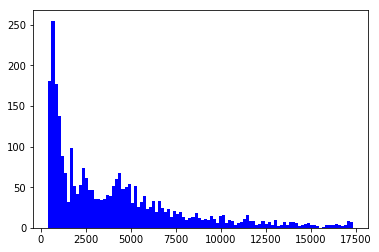

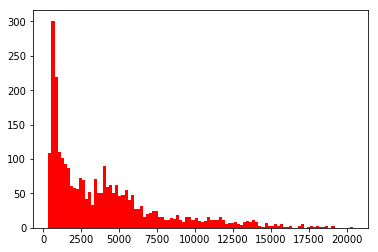

In [19]:
experiments.fit_evaluate(None, X_train, X_val, y_train, y_val, log_y=True, scale=True, exclude_features=None)